In [280]:
import string
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
import time
import math

## Loading data

In [115]:
acc_data = pd.read_csv('accented_data.csv', index_col=0)
unacc_data = pd.read_csv('unaccented_data.csv', index_col=0)

note: some positions are wrongly annotated due to the fact that in some words č,ć,đ,š or ž appear before the accent and therefore their position is marked

In [116]:
acc_data['Word'][10]

'abòrtus'

#### ONE HOT VECTOR EMBEDDING for letters

In [117]:

all_letters = string.ascii_letters + 'čćđšžČĆĐŠŽ .,;\'' # can be lowercase or uppercase letters of English alphabet, whitespace or interpunction marks
n_letters = len(all_letters)

# index of a letter in string all_letters for one-hot encoding
def letter_to_idx(letter):
    return all_letters.find(letter)


#returns tensor of size <word_length x 1 x n_letters>.
def word_to_tensor(word):
    tensor = torch.zeros(len(word),1,n_letters)
    for letter_index, letter in enumerate(word):
        tensor[letter_index][0][letter_to_idx(letter)] = 1
    return tensor


In [118]:
print(word_to_tensor(unacc_data['Word'][10]).shape)
print(word_to_tensor(unacc_data['Word'][10])[2])
print(letter_to_idx('š'))

torch.Size([6, 1, 67])
tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
55


#### Simple RNN with 2 linear layers and log softmax 

In [196]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size,hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden),1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


n_categories = 17 #suppose no word is longer than 16 letters
hidden_size = 128
rnn = RNN(n_letters, hidden_size, n_categories)

In [173]:
#example for extracting likelihood for position of the accent considering 1st letter of the word
input = word_to_tensor(unacc_data['Word'][10])
hidden = torch.zeros(1, hidden_size)

output, hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8428, -2.8443, -2.8494, -2.8720, -2.7898, -2.8529, -2.7974, -2.8292,
         -2.8437, -2.7897, -2.7417, -2.8252, -2.8257, -2.7865, -2.7744, -2.9535,
         -2.9738]], grad_fn=<LogSoftmaxBackward0>)


In [175]:
def most_likely_position(output):
    return torch.argmax(output).item()

print("Predikcija pozicije naglaska: ",most_likely_position(output))
print("Duljina rijeci: ",len(unacc_data['Word'][10]))

Predikcija pozicije naglaska:  10
Duljina rijeci:  6


In [281]:
x_train, x_test, y_train, y_test = train_test_split(unacc_data['Word'], unacc_data['Accent index'], test_size=0.2, random_state=42, shuffle=True)

In [176]:
def random_training_example():

    sample = unacc_data.sample(n=1)
    acc_position = sample['Accent index'].item()
    word = sample['Word'].item()

    position_tensor = torch.tensor([acc_position], dtype=torch.long)
    word_tensor = word_to_tensor(word)
    return acc_position, word, position_tensor, word_tensor


In [177]:
#example
for i in range(10):
    acc_position, word, position_tensor, word_tensor = random_training_example()
    print(f'pozicija naglaska = {acc_position} / rijec = {word}')

pozicija naglaska = 2 / rijec = dativ
pozicija naglaska = 6 / rijec = kajakaštvo
pozicija naglaska = 4 / rijec = hematit
pozicija naglaska = 4 / rijec = ublažiti
pozicija naglaska = 2 / rijec = gerber
pozicija naglaska = 5 / rijec = alegoričan
pozicija naglaska = 1 / rijec = obavještajni
pozicija naglaska = 2 / rijec = radilica
pozicija naglaska = 2 / rijec = kapela
pozicija naglaska = 2 / rijec = jard


In [197]:
criterion = nn.NLLLoss()

In [198]:
def train(category_tensor, line_tensor, lr):
    hidden = rnn.init_hidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Dodaj gradijente parametara na njihove trenutne vrijednosti, pomnožene sa stopom učenja.
    for p in rnn.parameters():
        if p.grad is not None:
            p.data.add_(p.grad.data, alpha=-lr)

    return output, loss.item()

In [199]:
lr = 0.005
n_iters = 100000
print_every = 10000
plot_every = 1000

current_loss = 0
all_losses = []

for iteration in tqdm(range(1, n_iters + 1)):

    acc_position, word, position_tensor, word_tensor = random_training_example()
    output, loss = train(position_tensor, word_tensor, lr = lr)
    current_loss += loss


    if iteration % print_every == 0:
        guess = most_likely_position(output)
        correct = '✓' if guess == acc_position else f'✗ ({acc_position})'
        print(f'{iteration} {iteration / n_iters}% {loss} {word} / {guess} {correct}')


    if iteration % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

 10%|█         | 10121/100000 [00:16<02:16, 657.49it/s]

10000 0.1% 2.0665736198425293 obnoć / 2 ✗ (1)


 20%|██        | 20059/100000 [00:32<02:13, 597.98it/s]

20000 0.2% 1.5482251644134521 jedinčev / 2 ✗ (4)


 30%|███       | 30087/100000 [00:48<01:48, 647.04it/s]

30000 0.3% 0.7305673360824585 cehovski / 2 ✓


 40%|████      | 40109/100000 [01:04<01:37, 613.03it/s]

40000 0.4% 1.838734745979309 obavezan / 2 ✗ (1)


 50%|█████     | 50125/100000 [01:20<01:11, 694.42it/s]

50000 0.5% 0.2951764762401581 deblo / 2 ✓


 60%|██████    | 60117/100000 [01:36<00:58, 682.51it/s]

60000 0.6% 1.7247374057769775 imenovati / 1 ✓


 70%|███████   | 70081/100000 [01:51<00:44, 667.22it/s]

70000 0.7% 0.3855091631412506 ranac / 2 ✓


 80%|████████  | 80076/100000 [02:07<00:30, 645.82it/s]

80000 0.8% 3.8004047870635986 farmaceut / 2 ✗ (7)


 90%|█████████ | 90116/100000 [02:23<00:16, 612.73it/s]

90000 0.9% 0.44746485352516174 gatati / 2 ✓


100%|██████████| 100000/100000 [02:39<00:00, 628.11it/s]

100000 1.0% 3.320204257965088 alegorijski / 2 ✗ (5)


## Plots

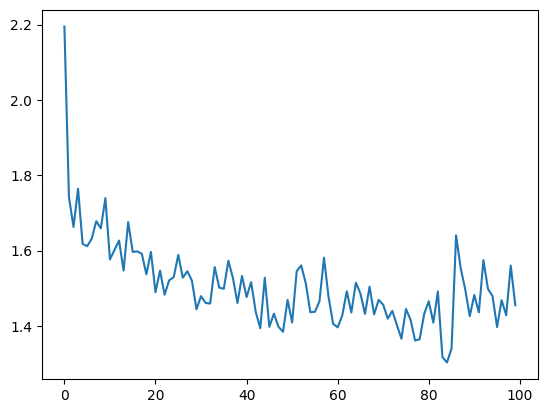

In [200]:
plt.plot(all_losses)

In [236]:

# Vrati output danog imena
def evaluate(word_tensor):
    hidden = rnn.init_hidden()

    for i in range(word_tensor.size()[0]):
        output, hidden = rnn(word_tensor[i], hidden)

    return output


In [ ]:
# Tenzor koji će pratiti točno pogođene kategorije.
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 5000

# Pusti primjere kroz mrežu i zabilježi one za koje je predviđena dobra kategorija.
for i in range(n_confusion):
    # Koristeći pomoćnu funkciju definirati testni primjer,
    # izračunati output, odrediti kategoriju za output te 
    # odgovarajući element u tenzoru confusion povećati za 1.
    ### Vaš kod ovdje
    acc_position, word, position_tensor, word_tensor = random_training_example()
    output = evaluate(word_tensor)
    pred = most_likely_position(output)
    confusion[int(acc_position)][int(pred)] += 1
    ### Kraj vašeg koda.


In [ ]:

class_counts = torch.zeros(n_categories, dtype=torch.float)
class_weights = torch.zeros(n_categories, dtype=torch.float)

for i in range(n_categories):
    class_counts[i] = confusion[i][:].sum()



In [250]:
class_counts[class_counts == 0] = 0.01  # Avoid division by zero

In [251]:
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()


In [254]:
class_weights

tensor([6.3224e-03, 1.1596e-03, 2.1397e-04, 1.4468e-03, 7.2798e-04, 1.1538e-03,
        1.2892e-03, 1.6194e-03, 2.7804e-03, 4.9100e-03, 7.4442e-03, 1.4888e-02,
        3.2967e-02, 1.5385e-01, 1.5385e-01, 4.6154e-01, 1.5385e-01])

In [253]:

# Normalizacija dijeljenjem svakog retka sumom tog retka.
for i in range(0,n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


<Axes: >

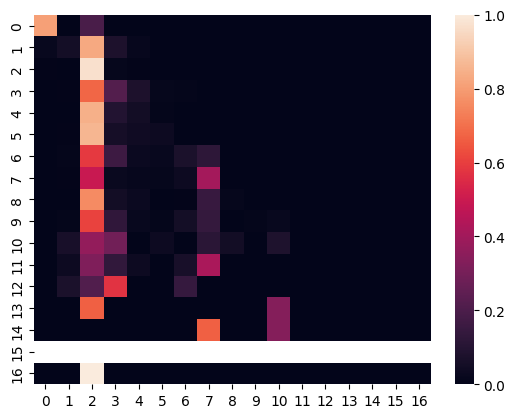

In [255]:
# Heatmap omogućuje "ljepši" prikaz matrice zabune
positions = unacc_data['Accent index'].unique().tolist()
positions.sort()
sns.heatmap(confusion, xticklabels=positions, yticklabels=positions)

## User test

In [257]:
def predict(input_word, n_predictions=3):
    print(f'\n> {input_word}')
    with torch.no_grad():
        output = evaluate(word_to_tensor(input_word))

        # Dohvati najizglednijih n kategorija
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item() #dohvati vrijednost vjerodostojnosti
            print(f'({value:.3f}) {topi[0][i].item()}')
            predictions.append([value, topi[0][i].item()])

predict('da')
predict('planina')
predict('čaša')


> da
(-0.534) 0
(-1.648) 2
(-3.266) 4

> planina
(-0.505) 2
(-2.066) 4
(-2.204) 5

> čaša
(-0.874) 2
(-1.610) 0
(-2.608) 5


In [189]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size,hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden),1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


n_categories = 17 #suppose no word is longer than 16 letters
hidden_size = 128*2
rnn_2 = RNN(n_letters, hidden_size, n_categories)

In [258]:
criterion_2 = nn.NLLLoss(weight=class_weights)

In [259]:
def train_2(category_tensor, line_tensor, lr):
    hidden = rnn_2.init_hidden()
    rnn_2.zero_grad(set_to_none=False)

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_2(line_tensor[i], hidden)

    loss = criterion_2(output, category_tensor)
    loss.backward()

    # Dodaj gradijente parametara na njihove trenutne vrijednosti, pomnožene sa stopom učenja.
    for p in rnn_2.parameters():
        p.data.add_(p.grad.data, alpha=-lr)

    return output, loss.item()

In [260]:
lr = 0.005
n_iters = 100000
print_every = 10000
plot_every = 1000

current_loss = 0
all_losses = []

for iteration in tqdm(range(1, n_iters + 1)):

    acc_position, word, position_tensor, word_tensor = random_training_example()
    output, loss = train_2(position_tensor, word_tensor, lr = lr)
    current_loss += loss


    if iteration % print_every == 0:
        guess = most_likely_position(output)
        correct = '✓' if guess == acc_position else f'✗ ({acc_position})'
        print(f'{iteration} {iteration / n_iters}% {loss} {word} / {guess} {correct}')


    if iteration % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

 10%|█         | 10083/100000 [00:22<03:34, 419.62it/s]

10000 0.1% 0.3309519290924072 hajka / 2 ✓


 20%|██        | 20060/100000 [00:43<02:55, 455.44it/s]

20000 0.2% 1.2907540798187256 heretik / 2 ✗ (4)


 30%|███       | 30088/100000 [01:06<02:38, 440.67it/s]

30000 0.3% 0.7304807305335999 lakmusov / 2 ✓


 40%|████      | 40084/100000 [01:30<02:21, 422.56it/s]

40000 0.4% 1.5470374822616577 kadifica / 2 ✗ (4)


 50%|█████     | 50060/100000 [01:55<02:25, 342.10it/s]

50000 0.5% 2.8646552562713623 germanističin / 6 ✗ (5)


 60%|██████    | 60046/100000 [02:20<01:48, 367.25it/s]

60000 0.6% 0.8873814344406128 nadbiskupski / 2 ✓


 70%|███████   | 70063/100000 [02:44<01:09, 433.14it/s]

70000 0.7% 1.2102593183517456 uglas / 2 ✗ (1)


 80%|████████  | 80049/100000 [03:09<00:55, 362.09it/s]

80000 0.8% 0.16850309073925018 gamad / 2 ✓


 90%|█████████ | 90045/100000 [03:33<00:25, 393.78it/s]

90000 0.9% 0.17424912750720978 nabavni / 2 ✓


100%|██████████| 100000/100000 [03:58<00:00, 418.72it/s]

100000 1.0% 0.4693966805934906 padobrančev / 7 ✓


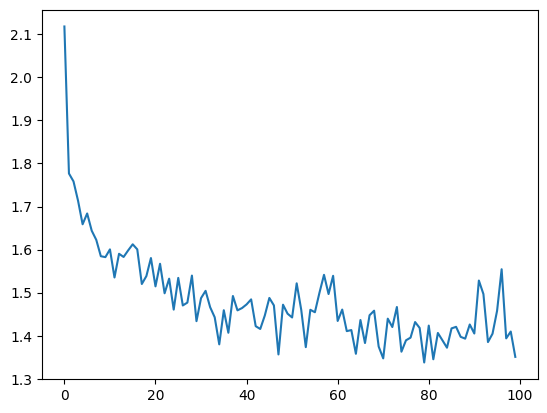

In [261]:
plt.plot(all_losses)

In [262]:
# Vrati output danog imena
def evaluate_2(word_tensor):
    hidden = rnn_2.init_hidden()

    for i in range(word_tensor.size()[0]):
        output, hidden = rnn_2(word_tensor[i], hidden)

    return output

In [263]:
# Tenzor koji će pratiti točno pogođene kategorije.
confusion_2 = torch.zeros(n_categories, n_categories)
n_confusion = 5000

# Pusti primjere kroz mrežu i zabilježi one za koje je predviđena dobra kategorija.
for i in range(n_confusion):
    # Koristeći pomoćnu funkciju definirati testni primjer,
    # izračunati output, odrediti kategoriju za output te 
    # odgovarajući element u tenzoru confusion povećati za 1.
    ### Vaš kod ovdje
    acc_position, word, position_tensor, word_tensor = random_training_example()
    output = evaluate_2(word_tensor)
    pred = most_likely_position(output)
    confusion_2[int(acc_position)][int(pred)] += 1
    ### Kraj vašeg koda.

# Normalizacija dijeljenjem svakog retka sumom tog retka.
for i in range(0,n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

<Axes: >

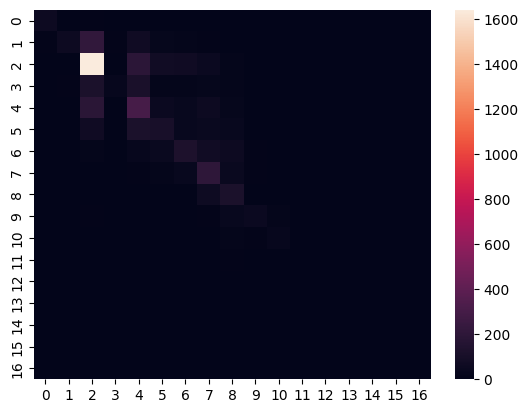

In [264]:
# Heatmap omogućuje "ljepši" prikaz matrice zabune
positions = unacc_data['Accent index'].unique().tolist()
positions.sort()
sns.heatmap(confusion_2, xticklabels=positions, yticklabels=positions)

In [271]:
def predict_2(input_word, n_predictions=3):
    print(f'\n> {input_word}')
    with torch.no_grad():
        output = evaluate_2(word_to_tensor(input_word))

        # Dohvati najizglednijih n kategorija
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item() #dohvati vrijednost vjerodostojnosti
            print(f'({value:.3f}) {topi[0][i].item()}')
            predictions.append([value, topi[0][i].item()])


In [274]:
predict_2('da')


> da
(-0.905) 2
(-1.059) 0
(-2.753) 4


## GRU

In [ ]:
class GRU_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_RNN, self).__init__()
        self.hidden_size = hidden_size

        self.gru = nn.GRU(input_size, hidden_size)

        self.h1 = nn.Linear(hidden_size, hidden_size)
        self.h2 = nn.Linear(hidden_size, hidden_size)
        self.h3 = nn.Linear(hidden_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        gru_output, hidden = self.gru(input, hidden)

        output = self.h1(gru_output[-1, :])
        output = torch.relu(output)
        output = self.h2(output)
        output = torch.relu(output)
        output = self.h3(output)
        output = self.softmax(output)

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


input_size = n_letters  # Number of input features
hidden_size = 128
output_size = 17  # Number of output classes

gru_rnn = GRU_RNN(input_size, hidden_size, output_size)
print(gru_rnn)

GRU_RNN(
  (gru): GRU(67, 128)
  (h1): Linear(in_features=128, out_features=128, bias=True)
  (h2): Linear(in_features=128, out_features=128, bias=True)
  (h3): Linear(in_features=128, out_features=17, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [276]:
criterion_nl = nn.NLLLoss(weight=class_weights)

In [ ]:
def train_gru(category_tensor, line_tensor, lr):
    hidden = gru_rnn.init_hidden()
    gru_rnn.zero_grad(set_to_none=False)

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_2(line_tensor[i], hidden)

    loss = criterion_2(output, category_tensor)
    loss.backward()

    # Dodaj gradijente parametara na njihove trenutne vrijednosti, pomnožene sa stopom učenja.
    for p in rnn_2.parameters():
        p.data.add_(p.grad.data, alpha=-lr)

    return output, loss.item()